In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns

# Loading the call log 

In [3]:
# phone calls dataset
phoneLog = pd.read_csv('./data/SprintNov2016.csv', na_values=['NA'])
phoneLog.dtypes


DATE            object
TIME            object
PHONE           object
DESTINATION     object
MINUTES USED     int64
dtype: object

In [4]:
phoneLog.head()

,DATE,TIME,PHONE,DESTINATION,MINUTES USED
0,11/29/2016,6:54 PM,469-237-6876,"Incoming,",1
1,11/29/2016,4:20 PM,469-909-9993,"GRAND PRAR,TX",1
2,11/29/2016,4:16 PM,469-909-9993,"GRAND PRAR,TX",1
3,11/29/2016,4:13 PM,469-909-9993,"GRAND PRAR,TX",1
4,11/29/2016,3:52 PM,469-909-9993,"GRAND PRAR,TX",1


In [4]:
phoneLog.isnull().sum()

DATE            0
TIME            0
PHONE           0
DESTINATION     0
MINUTES USED    0
dtype: int64

In [5]:
phoneLog.loc[phoneLog['DESTINATION'] == 'Incoming,', 'DESTINATION'] = 'Incoming'
phoneLog.head()

,DATE,TIME,PHONE,DESTINATION,MINUTES USED
0,11/29/2016,6:54 PM,469-237-6876,Incoming,1
1,11/29/2016,4:20 PM,469-909-9993,"GRAND PRAR,TX",1
2,11/29/2016,4:16 PM,469-909-9993,"GRAND PRAR,TX",1
3,11/29/2016,4:13 PM,469-909-9993,"GRAND PRAR,TX",1
4,11/29/2016,3:52 PM,469-909-9993,"GRAND PRAR,TX",1


<b><u>Check the dataset for nulls </u></b>

In [5]:
phoneLog.isnull().sum()

DATE            0
TIME            0
PHONE           0
DESTINATION     0
MINUTES USED    0
dtype: int64

In [7]:
phoneLog['DESTINATION'].unique()

array(['Incoming', 'GRAND PRAR,TX', 'BEAUMONT,TX', 'FRISCO,TX',
       'FLS CHURCH,VA', 'SYRACUSE,NY', 'CLARENCE,NY', 'ARLINGTON,TX',
       'MCKINNEY,TX', 'EDEN PRAIR,MN', 'DALLAS,TX'], dtype=object)

In [6]:
inout = phoneLog[['DESTINATION','MINUTES USED']]
inout_group = pd.DataFrame(inout.groupby('DESTINATION')['MINUTES USED'].sum()).reset_index()
inout_group


,DESTINATION,MINUTES USED
0,"ARLINGTON,TX",5
1,"BEAUMONT,TX",66
2,"CLARENCE,NY",3
3,"DALLAS,TX",1
4,"EDEN PRAIR,MN",1
5,"FLS CHURCH,VA",3
6,"FRISCO,TX",63
7,"GRAND PRAR,TX",38
8,"Incoming,",112
9,"MCKINNEY,TX",5


In [8]:
outg = inout_group.loc[inout_group['DESTINATION'].str.strip() != 'Incoming']
outg

outg.loc[outg['DESTINATION'].str.contains(','), 'State'] = outg['DESTINATION'].str.split(',').str.get(1)
outg.loc[outg['DESTINATION'].str.contains(','), 'City'] = outg['DESTINATION'].str.split(',').str.get(0)
outg.head()



,DESTINATION,MINUTES USED,State,City
0,"ARLINGTON,TX",5,TX,ARLINGTON
1,"BEAUMONT,TX",66,TX,BEAUMONT
2,"CLARENCE,NY",3,NY,CLARENCE
3,"DALLAS,TX",1,TX,DALLAS
4,"EDEN PRAIR,MN",1,MN,EDEN PRAIR


In [9]:
# Check for null
outg.isnull().sum()

DESTINATION     0
MINUTES USED    0
State           0
City            0
dtype: int64

Get all unique end points for the call. 
The list shows all the unique details for all call logs

In [10]:
from pygeocoder import Geocoder
import time
countCity = 0
locs = []
for addr in outg['City']:
    countCity += 1
    if(countCity % 10 == 0):
        time.sleep(1)
    locs.append(Geocoder.geocode(addr))
    print(countCity)

geo_info = pd.DataFrame(
    [ (addr.city, addr.latitude, addr.longitude) for addr in locs ],
    columns=['city','latitude', 'longitude'])


1
2
3
4
5
6
7
8
9
10
11


In [13]:
geo_info['city'] = map(lambda x: str(x).upper(), geo_info['city'])
geo_info

,city,latitude,longitude
0,ARLINGTON,38.879970,-77.106770
1,BEAUMONT,30.080174,-94.126556
2,CLARENCE,42.982216,-78.577081
3,DALLAS,32.776664,-96.796988
4,EDEN PRAIRIE,44.854686,-93.470786
5,FALLS CHURCH,38.882334,-77.171091
6,FRISCO,33.150674,-96.823612
7,GRAND PRAIRIE,32.745964,-96.997785
8,TEMECULA,33.589814,-117.031666
9,MCKINNEY,33.197246,-96.639782


Merge the data

In [12]:
outg = outg.reset_index(drop=True)
result = pd.concat([outg, geo_info], axis=1).sort_values(by='MINUTES USED', ascending=False).reset_index(drop=True)
result

#result = pd.merge(outg, geo_info, how='left',left_on=['City'], right_on= ['city'])
#result

,DESTINATION,MINUTES USED,State,City,city,latitude,longitude
0,"Incoming,",112,,Incoming,TEMECULA,33.589814,-117.031666
1,"BEAUMONT,TX",66,TX,BEAUMONT,BEAUMONT,30.080174,-94.126556
2,"FRISCO,TX",63,TX,FRISCO,FRISCO,33.150674,-96.823612
3,"GRAND PRAR,TX",38,TX,GRAND PRAR,GRAND PRAIRIE,32.745964,-96.997785
4,"ARLINGTON,TX",5,TX,ARLINGTON,ARLINGTON,38.879970,-77.106770
5,"MCKINNEY,TX",5,TX,MCKINNEY,MCKINNEY,33.197246,-96.639782
6,"SYRACUSE,NY",4,NY,SYRACUSE,SYRACUSE,43.048122,-76.147424
7,"CLARENCE,NY",3,NY,CLARENCE,CLARENCE,42.982216,-78.577081
8,"FLS CHURCH,VA",3,VA,FLS CHURCH,FALLS CHURCH,38.882334,-77.171091
9,"DALLAS,TX",1,TX,DALLAS,DALLAS,32.776664,-96.796988


In [14]:
import plotly.plotly as py
py.sign_in('suyashshetty','KxER1TQoDYre6ZhOZZGa')

scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]

result['text'] = result['City'] + ', ' + result['State'] + '' + ' -> Calls: ' + result['MINUTES USED'].astype(str)

data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = result['longitude'],
        lat = result['latitude'],
        text = result['text'],
        mode = 'markers',
        marker = dict( 
            size = 8, 
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = result['MINUTES USED'],
            cmax = result['MINUTES USED'].max(),
            colorbar=dict(
                title="Outgoing Calls - September 2016"
            )
        ))]

layout = dict(
        title = 'Outgoing Call Distribution',
        colorbar = True,   
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5        
        ),
    )

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='September - 2016' )

In [16]:
limits = [(0,3),(4,8),(9,13),(13,16),(17,20)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","lightgrey"]
cities = []
scale = 1
length = len(result.index)

for i in range(len(limits)):
    if limits[i][0] <= length:
        lim = limits[i]
        upperlim = lim[1] if lim[1]<length else length-1
        print(str(lim[0]) + " - " + str(upperlim) )
        df_sub = result[lim[0]:upperlim]
        city = dict(
               type = 'scattergeo',
               locationmode = 'USA-states',
               lon = df_sub['longitude'],
               lat = df_sub['latitude'],
               text = df_sub['text'],
               marker = dict(
                   size = (df_sub['MINUTES USED'] + 1) * 20,
                   color = colors[i],
                   line = dict(width=0.5, color='rgb(40,40,40)'),
                   sizemode = 'area'
         ),
        name = '{0} - {1}'.format(result['MINUTES USED'].iloc[upperlim],result['MINUTES USED'].iloc[lim[0]]) )
        cities.append(city)

        layout = dict(
            title = 'Nov 2016 Call Distribution <br>(Click legend to toggle traces)',
            showlegend = True,
            geo = dict(
                scope='usa',
                projection=dict( type='albers usa' ),
                showland = True,
                landcolor = 'rgb(217, 217, 217)',
                subunitwidth=1,
                countrywidth=1,
                subunitcolor="rgb(255, 255, 255)",
                countrycolor="rgb(255, 255, 255)"
            ),
        )

fig = dict( data=cities, layout=layout )
py.iplot( fig, validate=False, filename='d3-bubble-map-outgoing-calls-nov-2016' )

0 - 3
4 - 8
9 - 10


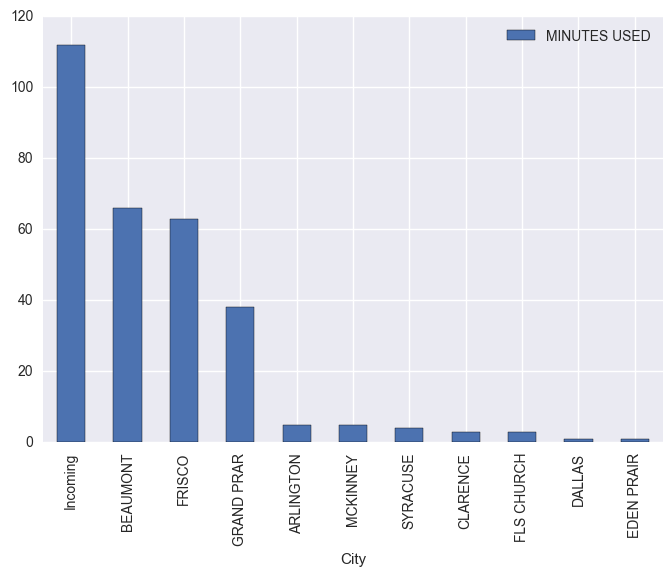

In [17]:
import matplotlib.pyplot as plt
result.plot(x='City', y='MINUTES USED', kind='bar', layout=[('MINUTES USED')])

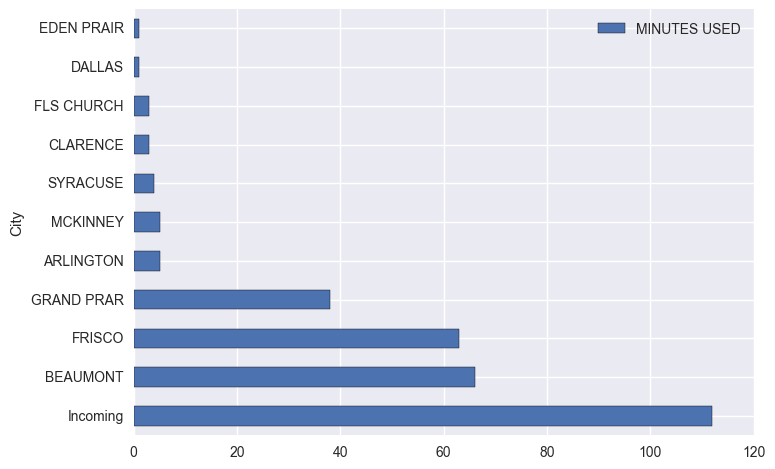

In [18]:
result.plot(x='City', y='MINUTES USED', kind='barh')

# Top 10 Outgoing

In [19]:
calls = phoneLog[['PHONE','MINUTES USED', 'DESTINATION']]
calls_outgoing = calls.loc[calls['DESTINATION'] != 'Incoming']
#calls_filter.loc[calls_filter['DESTINATION'] != 'Incoming'].count()
calls_out_grp = pd.DataFrame(calls_outgoing.groupby('PHONE')['MINUTES USED'].sum()).reset_index()
Top10_Outgoing = calls_out_grp.sort_values(by='MINUTES USED', ascending=False)[:10].reset_index()
Top10_Outgoing

,index,PHONE,MINUTES USED
0,5,409-203-9621,68
1,11,469-664-3506,47
2,3,214-909-1846,41
3,18,469-996-9556,23
4,16,469-909-9993,21
5,9,469-601-0682,14
6,19,571-230-7235,10
7,4,315-807-1313,9
8,27,972-689-3811,9
9,25,972-363-5342,7


# Top 10 Incoming

In [21]:
calls = phoneLog[['PHONE','MINUTES USED', 'DESTINATION']]
calls_incoming = calls.loc[calls['DESTINATION'] == 'Incoming,']
#calls_filter.loc[calls_filter['DESTINATION'] != 'Incoming'].count()
calls_in_grp = pd.DataFrame(calls_incoming.groupby('PHONE')['MINUTES USED'].sum()).reset_index()
Top10_Incoming = calls_in_grp.sort_values(by='MINUTES USED', ascending=False)[:10].reset_index()
Top10_Incoming

,index,PHONE,MINUTES USED
0,1,214-909-1846,41
1,7,469-601-0682,13
2,13,469-996-9556,7
3,14,571-230-7235,7
4,8,469-664-3506,6
5,2,315-807-1313,5
6,19,972-730-0033,5
7,18,972-689-3811,5
8,10,469-767-0925,3
9,15,682-716-8478,3


# Common numbers in Top 10 call list

In [22]:
pd.Series(list(set(Top10_Outgoing['PHONE']).intersection(set(Top10_Incoming['PHONE']))))

0    469-601-0682
1    315-807-1313
2    469-664-3506
3    571-230-7235
4    469-996-9556
5    972-689-3811
6    214-909-1846
dtype: object